## Part 1.2 - Lack of data
#### *Pol Roca Llaberia*

In this notebook we will analyze how the lack of data affects the performance of the baseline model before trying to improve it. To do that, we will decrease the size of the training set.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
Ns = [5000, 1000, 500, 300]

In [4]:
X_train = X_train[:max(Ns)]
y_train = y_train[:max(Ns)]
X_test = X_test[:2500]
y_test = y_test[:2500]

# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [5]:
print(X_train.shape)
print(X_test.shape)
np.unique(y_test, return_counts=True)

(5000, 28, 28, 1)
(2500, 28, 28, 1)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([219, 287, 276, 254, 275, 221, 225, 257, 242, 244]))

In [6]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(20, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes))
    return model

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2880)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                28810     
Total params: 29,330
Trainable params: 29,330
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We save the model weights so that each experiment starts from the same exact point with the same randomness

In [9]:
model.save_weights('initial.h5')

In [10]:
histories = []
metrics = []
epochs = 50

for N in Ns:
    model.load_weights('initial.h5')
    history = model.fit(X_train[:N], 
                        y_train[:N], 
                        epochs=epochs, 
                        batch_size=32, 
                        validation_data=(X_test, y_test), 
                        verbose=1)
    histories.append(history.history)
    metrics.append(model.evaluate(X_test, y_test))

Epoch 1/50
157/157 [==============================] - 30s 8ms/step - loss: 31.5604 - accuracy: 0.3993 - val_loss: 1.9071 - val_accuracy: 0.3432
Epoch 2/50
157/157 [==============================] - 1s 4ms/step - loss: 1.3661 - accuracy: 0.5462 - val_loss: 1.1006 - val_accuracy: 0.6588
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 0.6097 - accuracy: 0.8099 - val_loss: 0.7458 - val_accuracy: 0.8020
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4765 - accuracy: 0.8554 - val_loss: 0.7271 - val_accuracy: 0.8084
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3697 - accuracy: 0.8824 - val_loss: 0.7269 - val_accuracy: 0.8292
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3946 - accuracy: 0.8794 - val_loss: 0.8294 - val_accuracy: 0.8108
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3645 - accuracy: 0.8852 - val_loss: 1.0316 - val_accuracy: 0.7416
Epoc

In [24]:
print(Ns)
for loss, acc in np.round(metrics, 2):
    print(f'loss: {loss:.2f} accuracy: {acc:.2f}')

[5000, 1000, 500, 300]
loss: 1.61 accuracy: 0.89
loss: 1.14 accuracy: 0.84
loss: 2.31 accuracy: 0.74
loss: 2.94 accuracy: 0.65


In [22]:
def plot_curves(history, axes, title=''):
    # plot accuracy
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epochs = range(1, len(acc)+1)

    ax = axes[0]
    ax.plot(epochs, acc, 'b', label='Training Acc')
    ax.plot(epochs, val_acc, 'r', label='Validation Acc')
    ax.set_title('Accuracy curves | ' + title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.grid(alpha=0.4)
    ax.legend()

    # plot validation loss
    loss = history['loss']
    val_loss = history['val_loss']

    ax = axes[1]
    ax.plot(epochs, loss, 'b', label='Training loss')
    ax.plot(epochs, val_loss, 'r', label='Validation loss')
    ax.set_title('Loss curves | ' + title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(alpha=0.4)
    ax.legend()

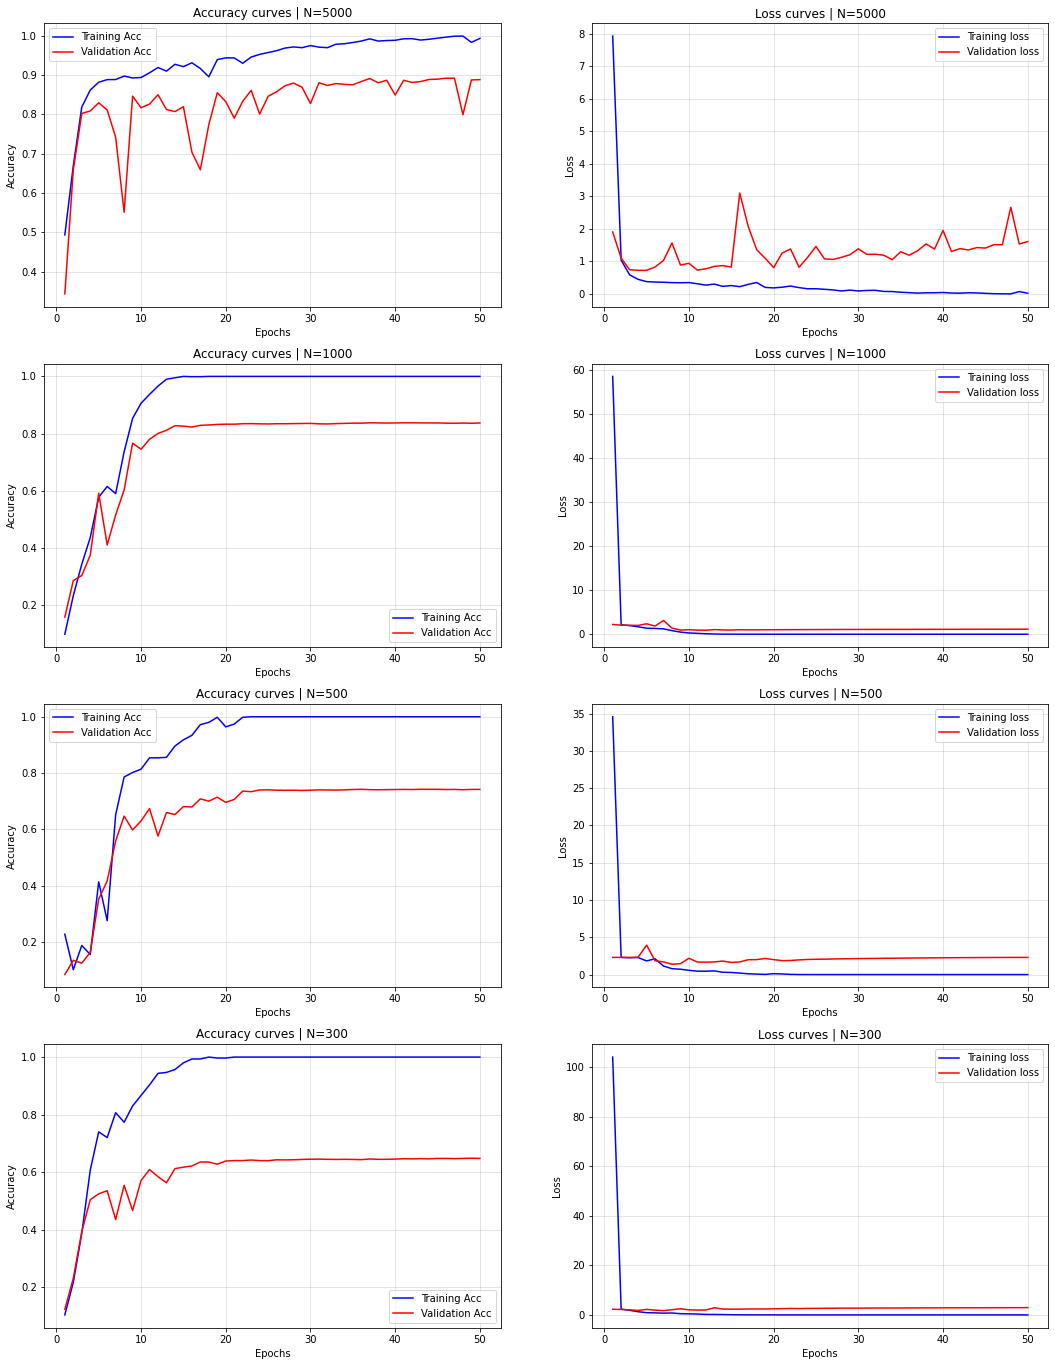

In [23]:
fig, axes = plt.subplots(len(histories), 2, figsize=(18, 6*len(histories)))

for i, history in enumerate(histories):
    plot_curves(history, axes[i], f'N={Ns[i]}')

plt.show()

### Observations

The plots clearly show how the lack of data compromises the performance of the model. Normally, deeper models have more parameters and need more data and training, but in this case, this model is quite shallow and we could still see a noticeable difference.

The gap between the validation and training loss is greater the less data the models had, but the scale (because of the huge loss at the beginning) makes it seem the other way around. We always can check the cell after fitting the model which shows these same metrics from the last epoch more clearly.

Another aspect that we can observe is that the first model does not come to the point where it has memorized the training set, as the accuracy is not perfect, so that it is able to achieve that accuracy by properly generalizing the images. A situation that is totally different for models with 1000, 500, and 300 instances, where in their plots we can spot perfect straight lines. My hypothesis is that these models *have* memorized the training images, and all the correct predictions on the test images are those that are similar to the memorized ones from the train set, and no more. That could be why there is a straight line in the accuracy and loss curves, because they are in the extreme case with already only two type of predictions: perfectly classfied instances and unknown badly classified instances. For this reason, the overfitting does not make validation loss ramp up much, because the generalization has already saturated to the worst.

---